In [1]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss
from sklearn.svm import SVC
import joblib

In [2]:
# 定义文件序号列表
sizes = [128, 256, 512, 1024, 2048, 4096]

file_path_train = []
file_path_test  = []
# 循环遍历每个文件序号，并加载相应的 CSV 文件
for size in sizes:
    file_path_train.append(f'../preprocessed/combined_features_{size}.csv')
    file_path_test.append(f'../preprocessed/combined_features_{size}_test.csv')

In [3]:
# 初始化字典存储X_train和y_train数据集
# scaler = StandardScaler()
X_trains = {}
y_trains = {}
X_tests = {}
y_tests = {}
# 循环处理每个文件
for size, file_path in zip(sizes, file_path_train):
    # 读取数据集
    df = pd.read_csv(file_path)
    # 打乱数据集
    df = shuffle(df, random_state=42)
    # 分离标签和特征
    y_trains[size] = df['label']
    X_trains[size] = df.drop('label', axis=1)
for size, file_path in zip(sizes, file_path_test):
    # 读取数据集
    df = pd.read_csv(file_path)
    # 打乱数据集
    df = shuffle(df, random_state=42)
    # 分离标签和特征
    y_tests[size] = df['label']
    X_tests[size] = df.drop('label', axis=1)


C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=300000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=300000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=300000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=300000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (ma

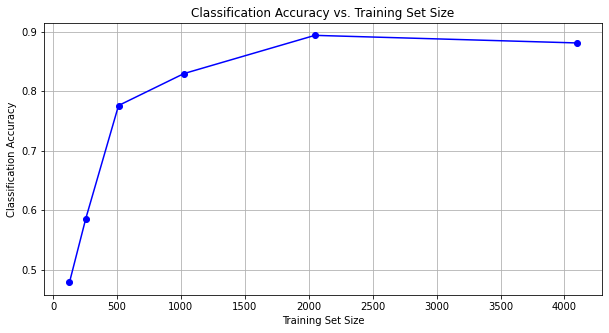

In [4]:
accuracies_svm = []

# 训练模型并评估准确度
for size in sizes:
    X_train = X_trains[size]
    X_test  = X_tests [size]
    y_train = y_trains[size]
    y_test  = y_tests [size]
    model = SVC(kernel='linear', C=5545, gamma='auto', max_iter=300000)
    # model = SVC(kernel="linear", decision_function_shape="ovo")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = np.mean(y_pred == y_test)
    accuracies_svm.append((size, accuracy))
# 数据排序（可选，如果数据集未按顺序添加）
accuracies_svm.sort()

# 分解列表以便绘图
sizes, accuracy_scores = zip(*accuracies_svm)

# 绘制图形
plt.figure(figsize=(10, 5))
plt.plot(sizes, accuracy_scores, marker='o', linestyle='-', color='b')
plt.title('Classification Accuracy vs. Training Set Size')
plt.xlabel('Training Set Size')
plt.ylabel('Classification Accuracy')
plt.grid(True)
plt.show()


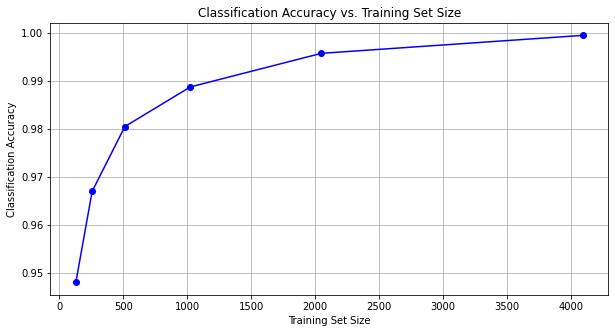

In [5]:
accuracies = []

# 训练模型并评估准确度
for size in sizes:
    X_train = X_trains[size]
    X_test  = X_tests [size]
    y_train = y_trains[size]
    y_test  = y_tests [size]
    model = xgb.XGBClassifier(eval_metric='logloss')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = np.mean(y_pred == y_test)
    accuracies.append((size, accuracy))
# 数据排序（可选，如果数据集未按顺序添加）
accuracies.sort()

# 分解列表以便绘图
sizes, accuracy_scores = zip(*accuracies)

# 绘制图形
plt.figure(figsize=(10, 5))
plt.plot(sizes, accuracy_scores, marker='o', linestyle='-', color='b')
plt.title('Classification Accuracy vs. Training Set Size')
plt.xlabel('Training Set Size')
plt.ylabel('Classification Accuracy')
plt.grid(True)
plt.show()


# 加上递归特征消除和交叉验证后

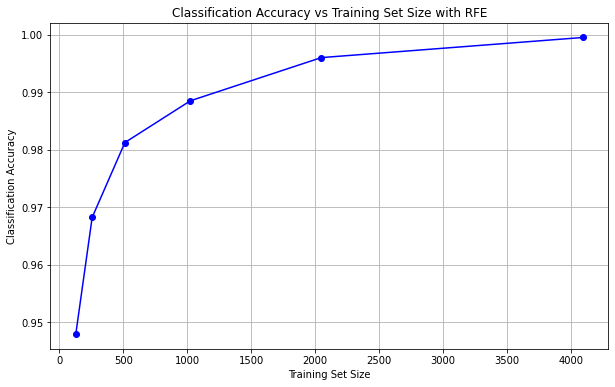

In [6]:
accuracies_ = []

# 进行交叉验证和特征选择
for size in sizes:
    X_train = X_trains[size]
    y_train = y_trains[size]
    X_test  = X_tests [size]
    y_test  = y_tests [size]
    # 创建XGBoost模型
    estimator = xgb.XGBClassifier(eval_metric='logloss')
    # 创建RFE与交叉验证
    rfecv = RFECV(estimator=estimator, step=1, cv=StratifiedKFold(5), scoring='accuracy')
    rfecv.fit(X_train, y_train)
    # 保存模型到磁盘
    model_filename = f'./model_save/xgb_model_size_{size}.joblib'
    joblib.dump(rfecv, model_filename)
    # 使用训练好的 RFE 模型对测试集进行预测
    y_pred = rfecv.predict(X_test)
    accuracy = np.mean(y_pred == y_test)
    accuracies_.append(accuracy)

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(sizes, accuracies_, marker='o', linestyle='-', color='b')
plt.title('Classification Accuracy vs Training Set Size with RFE')
plt.xlabel('Training Set Size')
plt.ylabel('Classification Accuracy')
plt.grid(True)
plt.show()

In [7]:
print(accuracies)
print(accuracies_)

[(128, 0.948), (256, 0.967), (512, 0.9805), (1024, 0.98875), (2048, 0.99575), (4096, 0.9995)]
[0.948, 0.96825, 0.98125, 0.9885, 0.996, 0.9995]


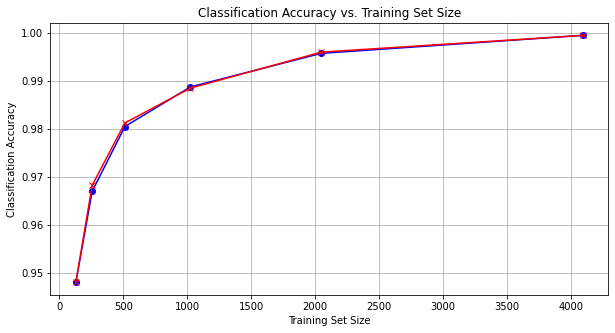

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(sizes, accuracy_scores, marker='o', linestyle='-', color='b')
plt.plot(sizes, accuracies_, marker='x', linestyle='-', color='r')
plt.title('Classification Accuracy vs. Training Set Size')
plt.xlabel('Training Set Size')
plt.ylabel('Classification Accuracy')
plt.grid(True)
plt.show()

# 模型保存和加载方法

In [9]:
# 加载模型
model_filename = f'./model_save/xgb_model_size_{size}.joblib'
rfecv_loaded = joblib.load(model_filename)

# 对测试集进行预测
y_pred_loaded = rfecv_loaded.predict(X_test)